## Data Overview

In [1]:
import pandas as pd

df = pd.read_csv('train.csv')

/Users/wangyuxi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
237,238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,C.A. 31921,26.2500,NaN,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.7500,NaN,Q
723,724,0,2,"Hodges, Mr. Henry Price",male,50.0,0,0,250643,13.0000,NaN,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S


In [3]:
columns = ['Pclass', 'SibSp', 'Parch','Cabin','Embarked']

for col in columns:
    print(f"--- {col} ---")
    print("Unique values:", df[col].unique(),
          "\n Number of unique values:", df[col].nunique(),
          "\n Value counts:", df[col].value_counts())

--- Pclass ---
Unique values: [3 1 2] 
 Number of unique values: 3 
 Value counts: Pclass
3    491
1    216
2    184
Name: count, dtype: int64
--- SibSp ---
Unique values: [1 0 3 4 2 5 8] 
 Number of unique values: 7 
 Value counts: SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
--- Parch ---
Unique values: [0 1 2 5 3 4 6] 
 Number of unique values: 7 
 Value counts: Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
--- Cabin ---
Unique values: [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.duplicated().sum() 

0

## Data Cleaning

### Drop Columns
- `Name`
- `Ticket`

### Convert Columns
- `Sex`: change to boolean (`male=True`, `female=False`)

### Feature Engineering
- `Cabin`: create `has_cabin` column (0 if missing, 1 if present)
- Drop original `Cabin` column

### One-Hot Encoding
- `Embarked`: create dummy variables for `C`, `Q`, `S`

### Fill Missing Float Values
- `Age`: fill missing values with median
- `Fare`: fill missing values with median


In [7]:
df['Age'].fillna(df['Age'].median(), inplace=True)

df.drop(["Name","Ticket"], axis=1, inplace=True)

df['Sex'] = df['Sex'].map({'male': True, 'female': False})

df['Has_Cabin'] = df['Cabin'].notnull()
df.drop(["Cabin"], axis=1, inplace=True)

df_encoded= pd.get_dummies(df, columns=['Embarked'])

## Correlation Check

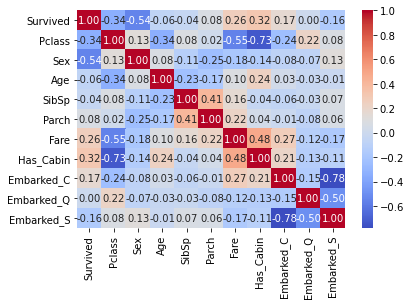

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_encoded.drop(["PassengerId"], axis=1).corr()  , annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [9]:
df_encoded

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,True,22.0,1,0,7.2500,False,False,False,True
1,2,1,1,False,38.0,1,0,71.2833,True,True,False,False
2,3,1,3,False,26.0,0,0,7.9250,False,False,False,True
3,4,1,1,False,35.0,1,0,53.1000,True,False,False,True
4,5,0,3,True,35.0,0,0,8.0500,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,True,27.0,0,0,13.0000,False,False,False,True
887,888,1,1,False,19.0,0,0,30.0000,True,False,False,True
888,889,0,3,False,28.0,1,2,23.4500,False,False,False,True
889,890,1,1,True,26.0,0,0,30.0000,True,True,False,False


## Y Balance Checking 

In [10]:
print(df_encoded['Survived'].value_counts())
print(df_encoded['Survived'].value_counts(normalize=True))

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


## Model Introduction

We will use the following models:  
- **Logistic Regression**  
- **Random Forest**  
- **XGBoost**

### Hyperparameter Tuning
We will perform **parameter grid search** to find the best model settings for optimal performance.


In [11]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['PassengerId', 'Survived'], axis=1)
y = df_encoded['Survived']

In [37]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Logistic Regression

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # needed for l1 penalty
    'class_weight': ['balanced', None]
}

lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Best CV score:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.8100558659217877
Best CV score: 0.7934699103713189


In [15]:
# Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 500], #more trees usually stabilize results
    'max_depth': [None, 5, 10, 15], #prevents overfitting if dataset is small
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Best CV score:", grid_search.best_score_)

Best Hyperparameters: {'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Test Accuracy: 0.8156424581005587
Best CV score: 0.8300305328474342


In [39]:
#XGBoost / LightGBM

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

class_dist = df['Survived'].value_counts(normalize=True)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [class_dist[0] / class_dist[1], None]
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)


print("Best Hyperparameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Best CV score:", grid_search.best_score_)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': None, 'subsample': 0.8}
Test Accuracy: 0.7988826815642458
Best CV score: 0.8398699891657639


# Output

In [40]:
test = pd.read_csv("test.csv")
train = pd.read_csv('train.csv')

In [41]:
# Data cleaning process

def clean(df):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df.drop(["Name","Ticket"], axis=1, inplace=True)

    df['Sex'] = df['Sex'].map({'male': True, 'female': False})
    
    df['Has_Cabin'] = df['Cabin'].notnull()
    df.drop(["Cabin"], axis=1, inplace=True)

    df_encoded= pd.get_dummies(df, columns=['Embarked'])
        
    return df_encoded


In [42]:
train = clean(train)
test = clean(test)

In [43]:
# --- Features & Target ---
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_train = train[features]
y_train = train['Survived']
X_test = test[features]

In [44]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# --- Models ---
ensemble = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb),('lr', best_lr)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [45]:
# --- Output CSV ---
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived": y_pred})
submission.to_csv("titanic_submission.csv", index=False)
print("Prediction saved to titanic_submission.csv")

Prediction saved to titanic_submission.csv
